In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 20
import matplotlib.patches as mpatches

from timeit import default_timer as timer

import my_settings  as st         # configuration file
from helper import *              # load/save   
import util as ut              # utility function
# Simple non zero mean Gaussian Process class adapted for the emulator
from gaussproc_emu import *

# Predict all...

# Start by loading the training results

In [3]:
root_dir = "./"

In [4]:
cosmologies = load_arrays(root_dir + 'trainingset/components', 'cosmologies')
print(f"Cosmo: nber of training Cosmo points {cosmologies.shape[0]} for {cosmologies.shape[1]} params")

Cosmo: nber of training Cosmo points 1000 for 5 params


In [5]:
# Growth factor
growth_factor = load_arrays(root_dir + 'trainingset/components', 'growth_factor')
print(f"Growth Fact: nber of training points {growth_factor.shape[0]} for {growth_factor.shape[1]} z (linear)")
n_gf = growth_factor.shape[1]
assert n_gf == st.nz, "Growth: Hummm something strange..."
print(f"The number of GPs to model Growth={n_gf} (= nber of z_bins) ")
folder_gf = root_dir + '/pknl_components' + st.d_one_plus + '/gf'
arg_gf = [[cosmologies, growth_factor[:, i], st.gf_args, folder_gf, 'gp_' + str(i)] for i in range(n_gf)]


# Pk Linear 
pk_linear = load_arrays(root_dir +'trainingset/components', 'pk_linear')
print(f"Linear Pk: nber of training points {pk_linear.shape[0]} for {pk_linear.shape[1]} k (log)")
n_pl = pk_linear.shape[1]
assert n_pl == st.nk, "Pk lin: Hummm something strange..."
print(f"The number of GPs to model Pklin={n_pl} (= nber of k_bins) ")
folder_pl = root_dir + '/pknl_components' + st.d_one_plus + '/pl'
arg_pl = [[cosmologies, pk_linear[:, i], st.pl_args, folder_pl, 'gp_' + str(i)] for i in range(n_pl)]

# Q-func (= 1+q)
q_function = load_arrays(root_dir +'trainingset/components', 'q_function')
print(f"Q-func: nber of training points {q_function.shape[0]} for {q_function.shape[1]} z x k(lin,log)")
n_qf = q_function.shape[1]
assert n_qf == st.nk * st.nz, "Qfunc: Hummm something strange..."
print(f"The number of GPs to model Q-func={n_qf}")
folder_qf = root_dir + '/pknl_components' + st.d_one_plus + '/qf'
if st.emu_one_plus_q:
    arg_qf = [[cosmologies, 1.0 + q_function[:, i], st.qf_args, folder_qf, 'gp_' + str(i)] for i in range(n_qf)]
else:
    arg_qf = [[cosmologies, q_function[:, i], st.qf_args, folder_qf, 'gp_' + str(i)] for i in range(n_qf)]

Growth Fact: nber of training points 1000 for 20 z (linear)
The number of GPs to model Growth=20 (= nber of z_bins) 
Linear Pk: nber of training points 1000 for 40 k (log)
The number of GPs to model Pklin=40 (= nber of k_bins) 
Q-func: nber of training points 1000 for 800 z x k(lin,log)
The number of GPs to model Q-func=800


# Test with 1 new set of cosmo para.

In [6]:
par = {'omega_cdm': 0.12, 'omega_b': 0.022, 'ln10^{10}A_s': 2.9, 'n_s': 1.0, 'h': 0.75}

theta_star = jnp.array([val for val in par.values()])

#Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h
theta_star

DeviceArray([0.12 , 0.022, 2.9  , 1.   , 0.75 ], dtype=float64)

## Growth factor

In [7]:
#y_trans = False
st.gf_args['y_trans']

False

In [8]:
gf_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.gf_args['y_trans'],
                         use_mean=st.use_mean)

In [9]:
pred_gf = jnp.zeros(n_gf)
for i_gf in range(n_gf):
    gf_model.load_info( arg_gf[i_gf][3], arg_gf[i_gf][4])
    pred_gf_cur = gf_model.simple_predict(theta_star)
    #print(f"[{i_gf}]",gf_model.kernel_hat, gf_model.beta_hat, pred_gf_cur)
    pred_gf= pred_gf.at[i_gf].set(pred_gf_cur)

In [10]:
pred_gf

DeviceArray([0.99999996, 0.79174472, 0.62596249, 0.49891977, 0.4025074 ,
             0.32935536, 0.27328264, 0.22975057, 0.19561521, 0.16824215,
             0.14609959, 0.12797339, 0.11297025, 0.10042569, 0.08983944,
             0.08083005, 0.07310333, 0.06642985, 0.06062888, 0.0555594 ],            dtype=float64)

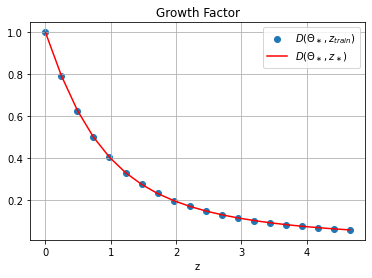

In [11]:
# training redshifts
zs=jnp.linspace(st.zmin, st.zmax, st.nz, endpoint=True)

z_new = jnp.linspace(st.zmin, st.zmax, 200, endpoint=True)
gf_new = jax.numpy.interp(z_new, zs, pred_gf)

plt.scatter(zs, pred_gf, label=r"$D(\Theta_\ast, z_{train})$")
plt.plot(z_new,gf_new,c="r", label=r"$D(\Theta_\ast,z_\ast)$")
plt.legend()
plt.xlabel("z")
plt.title("Growth Factor")
plt.grid();

# Linear Pk

In [12]:
st.pl_args['y_trans']

True

In [13]:
pl_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.pl_args['y_trans'],
                         use_mean=st.use_mean)

In [14]:
pred_pl = jnp.zeros(n_pl)
for i_pl in range(n_pl):
    pl_model.load_info(arg_pl[i_pl][3], arg_pl[i_pl][4])
    pred_pl_cur = pl_model.pred_original_function(theta_star)
    #print(f"[{i_gf}]",gf_model.kernel_hat, gf_model.beta_hat, pred_gf_cur)
    pred_pl= pred_pl.at[i_pl].set(pred_pl_cur)

In [15]:
# training k
ks = np.geomspace(st.k_min_h_by_Mpc, st.kmax, st.nk, endpoint=True)

In [16]:
k_new = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, 200, endpoint=True)
pl_new = jax.numpy.interp(k_new, ks, pred_pl)

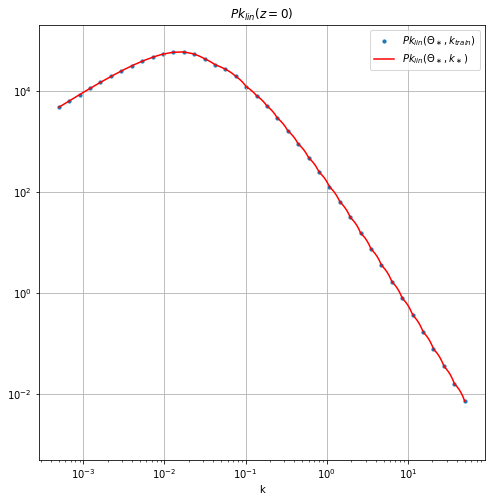

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(ks, pred_pl, s=10,label=r"$Pk_{lin}(\Theta_\ast, k_{train})$")
plt.plot(k_new,pl_new,c="r", label=r"$Pk_{lin}(\Theta_\ast,k_\ast)$")
plt.legend()
plt.xlabel("k")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$Pk_{lin} (z=0)$")
plt.ylim([5e-4,2e5])
plt.grid();

# Q-func

In [18]:
st.qf_args['y_trans']

True

In [19]:
qf_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.qf_args['y_trans'],          ######
                         use_mean=st.use_mean)

In [20]:
pred_qf = jnp.zeros(n_qf)
for i_qf in range(n_qf):
    qf_model.load_info(arg_qf[i_qf][3], arg_qf[i_qf][4])
    pred_qf_cur = qf_model.pred_original_function(theta_star)
    pred_qf= pred_qf.at[i_qf].set(pred_qf_cur)

In [21]:
pred_qf = pred_qf.reshape(st.nk, st.nz)

In [22]:
pred_qf.shape

(40, 20)

In [23]:
ks.shape,zs.shape

((40,), (20,))

In [24]:
ks

array([5.00000000e-04, 6.71699666e-04, 9.02360883e-04, 1.21223101e-03,
       1.62851033e-03, 2.18773969e-03, 2.93900804e-03, 3.94826143e-03,
       5.30409178e-03, 7.12551335e-03, 9.57240988e-03, 1.28595690e-02,
       1.72755365e-02, 2.32079442e-02, 3.11775367e-02, 4.18838820e-02,
       5.62667791e-02, 7.55887535e-02, 1.01545881e-01, 1.36416669e-01,
       1.83262062e-01, 2.46194132e-01, 3.30737032e-01, 4.44311908e-01,
       5.96888321e-01, 8.01859372e-01, 1.07721735e+00, 1.44713306e+00,
       1.94407759e+00, 2.61167254e+00, 3.50851914e+00, 4.71334228e+00,
       6.33190087e+00, 8.50627140e+00, 1.14273193e+01, 1.53514531e+01,
       2.06231319e+01, 2.77051017e+01, 3.72190151e+01, 5.00000000e+01])

In [25]:
zs

DeviceArray([0.        , 0.24526316, 0.49052632, 0.73578947, 0.98105263,
             1.22631579, 1.47157895, 1.71684211, 1.96210526, 2.20736842,
             2.45263158, 2.69789474, 2.94315789, 3.18842105, 3.43368421,
             3.67894737, 3.92421053, 4.16947368, 4.41473684, 4.66      ],            dtype=float64)

In [26]:
#interp2d (x,y,xp,yp,zp)
#    Args:
#        x, y: 1D arrays of point at which to interpolate. Any out-of-bounds
#            coordinates will be clamped to lie in-bounds.
#        xp, yp: 1D arrays of points specifying grid points where function values
#            are provided.
#       zp: 2D array of function values. For a function `f(x, y)` this must
#            satisfy `zp[i, j] = f(xp[i], yp[j])`
#    Returns:
#        1D array `z` satisfying `z[i] = f(x[i], y[i])`.

In [27]:
# qf_new[i] = qf_interp[k_new[i],z_new[i]]; len(k_new)=len(z_new) 
qf_new=ut.coogan_interp2d(k_new,z_new,ks,zs,pred_qf)   
qf_new_bis=jnp.array([ut.coogan_interp2d(k,z,ks,zs,pred_qf)  for k,z in zip(k_new,z_new)])
qf_new_jec=jnp.array([ut.jec_interp2d(k,z,ks,zs,pred_qf) for k,z in zip(k_new,z_new)])

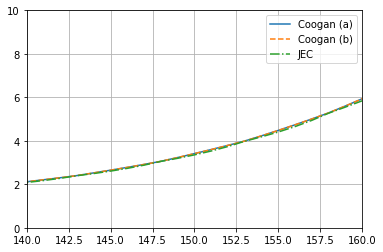

In [28]:
plt.plot(qf_new, label="Coogan (a)")
plt.plot(qf_new_bis,ls="--", label="Coogan (b)")
plt.plot(qf_new_jec,ls="-.", label="JEC")
plt.xlim([140,160])
plt.ylim([0,10])
plt.grid()
plt.legend();

# Pk non linear at z=0.5  pour $\Theta_\ast$

In [29]:
z_star = 0.5
D_star = jax.numpy.interp(z_star, zs, pred_gf)

In [30]:
D_star

DeviceArray(0.62105526, dtype=float64)

In [31]:
ks.shape, zs.shape

((40,), (20,))

In [32]:
z_star = 0.5
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, 100, endpoint=True)
pl_star_z0 = jax.numpy.interp(k_star, ks, pred_pl)
#z_star = jnp.array([z_star]*k_star.shape[0])
qf_star = jnp.array([ut.coogan_interp2d(k,z_star,ks,zs,pred_qf)   for k in k_star])

In [33]:
#qf_star

In [34]:
qf_star.shape, D_star, pl_star_z0.shape

((100,), DeviceArray(0.62105526, dtype=float64), (100,))

In [35]:
pl_star = D_star * pl_star_z0
pnl_star = pl_star * qf_star 

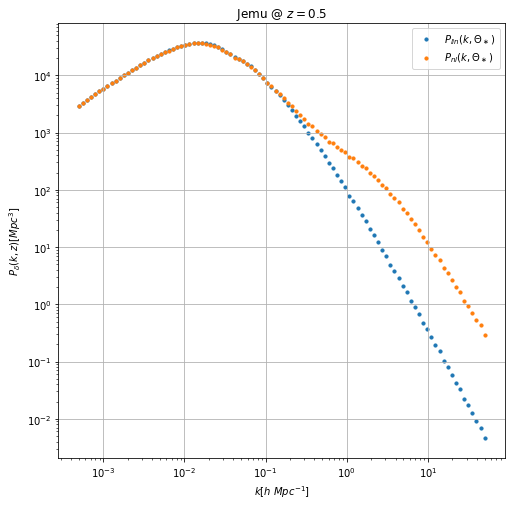

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(k_star,pl_star, s=10, label=r"$P_{lin}(k, \Theta_\ast)$")
plt.scatter(k_star,pnl_star, s=10,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [h\ Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(r"Jemu @ $z=0.5$");

In [261]:
from jemupk import *

In [262]:
emu = JemuPk()

New Pk Emulator


In [263]:
emu.load_all_gps(directory = root_dir + '/pknl_components' + st.d_one_plus)

In [264]:
par = {'omega_cdm': 0.12, 'omega_b': 0.022, 'ln10^{10}A_s': 2.9, 'n_s': 1.0, 'h': 0.75}
theta_star = jnp.array([val for val in par.values()])
#Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h
theta_star

DeviceArray([0.12 , 0.022, 2.9  , 1.   , 0.75 ], dtype=float64)

In [265]:
pred_gf, pred_pl, pred_qf = emu.gp_kzgrid_pred(theta_star)

In [266]:
pred_gf.shape,pred_pl.shape,pred_qf.shape

((40, 20), (20,), (40,))

In [267]:
N=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, N, endpoint=True)
z_star = 0.
pk_nl, gf, pk_lz0 = emu.interp_pk(theta_star, k_star,z_star)

(100.0, 100000.0)

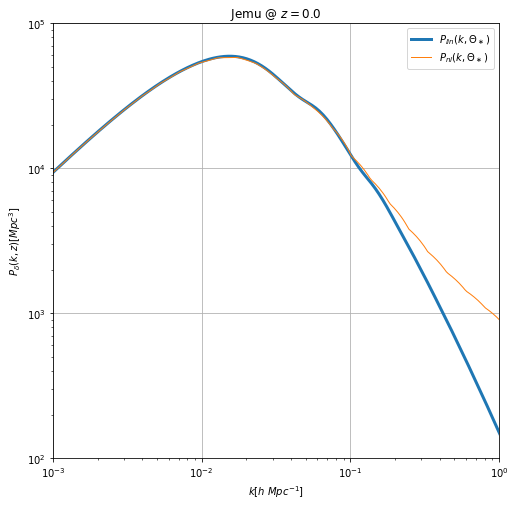

In [268]:
plt.figure(figsize=(8,8))
plt.plot(k_star,pk_lz0*gf, lw=3, label=r"$P_{lin}(k, \Theta_\ast)$")
plt.plot(k_star,pk_nl, lw=1,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [h\ Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(rf"Jemu @ $z={z_star}$");
plt.xlim([1e-3,1])
plt.ylim([1e2,1e5])

# Comparaison 

In [269]:
import jax_cosmo as jc
import pyccl as ccl

In [270]:
# Sur un jeu de theta cosmo de training

In [210]:
cosmologies

array([[0.12616742, 0.02163407, 2.72607173, 1.15724975, 0.73022459],
       [0.29972099, 0.02306631, 3.96075513, 0.86839526, 0.70286242],
       [0.13884111, 0.02485885, 3.173544  , 1.11576076, 0.76722837],
       ...,
       [0.38322584, 0.02537082, 4.64441174, 0.80712803, 0.64501174],
       [0.06389384, 0.01991875, 2.82671402, 1.28515481, 0.64342292],
       [0.2368161 , 0.02314526, 2.96121814, 0.95206408, 0.80532434]])

In [235]:
#Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h
#cosmologies[0]=array([0.12616742, 0.02163407, 2.72607173, 1.15724975, 0.73022459])
h_emu = 0.73022459
omega_c_emu = 0.12616742    # omega_c h^2
omega_b_emu = 0.02163407   #omega_b h^2
n_s_emu = 1.15724975
ln1010As_emu = 2.72607173
As_emu = 10**(-10)*np.exp(ln1010As_emu)

In [236]:
#h_emu = 0.75
#omega_c_emu = 0.12    # omega_c h^2
#omega_b_emu = 0.022   #omega_b h^2
#n_s_emu = 1.0
#ln1010As_emu=2.9
#As_emu = 10**(-10)*np.exp(ln1010As_emu)

## Attention: l'emulateur prend 'Omega_c h^2' et 'Omega_b h^2' contrairement à CCL et jax-cosmo 

In [237]:


omega_c_ccl = omega_c_emu/h_emu**2
omega_b_ccl = omega_b_emu/h_emu**2


sigma8_emu = ccl.Cosmology(
    Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, A_s=As_emu, n_s=n_s_emu, Neff=0,
    transfer_function='boltzmann_camb').sigma8()

cosmo_ccl= ccl.Cosmology(
    Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Neff=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')

In [238]:
params_emu = {'omega_cdm': omega_c_emu, 'omega_b': omega_b_emu, 
             'ln10^{10}A_s':ln1010As_emu , 
             'n_s': n_s_emu, 'h': h_emu}
theta_star = jnp.array([val for val in params_emu.values()])
#Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h
theta_star

DeviceArray([0.12616742, 0.02163407, 2.72607173, 1.15724975, 0.73022459],            dtype=float64)

In [239]:
Nk=10*st.nk 
k_star = jnp.geomspace(5e-4, 5e1,Nk, endpoint=True)
z_star = 1.22631579
pk_nl, gf, pk_lz0 = emu.interp_pk(theta_star, k_star,z_star)

In [240]:
pk_nl /= h_emu**2
pk_lz0 /= h_emu**2

In [241]:
cosmo_jax = jc.Cosmology(Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Omega_k=0, w0=-1.0,wa=0.0)

pk_lin_ccl = ccl.linear_matter_power(cosmo_ccl, k_star*cosmo_jax.h, 1./(1+z_star)) #last is scale factor 1=>z=0

pk_lin_jc = jc.power.linear_matter_power(cosmo_jax,k_star, 1./(1+z_star))/cosmo_jax.h**3

(0.01, 1000000.0)

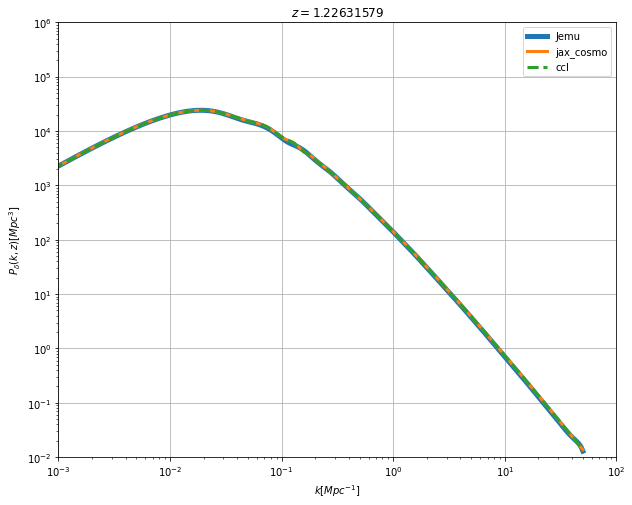

In [242]:
plt.figure(figsize=(10,8))
plt.plot(k_star,pk_lz0*gf,lw=5, label="Jemu")
plt.plot(k_star,pk_lin_jc,lw=3, label="jax_cosmo")
plt.plot(k_star,pk_lin_ccl,lw=3, ls="--",label="ccl")
#plt.plot(k_star,pk_nl, lw=1,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(rf"$z={z_star}$");
plt.xlim([1e-3,1e2])
plt.ylim([1e-2,1e6])

In [243]:
cosmo_ccl_EH= ccl.Cosmology(
    Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Neff=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')


cosmo_ccl_CAMB_nus= ccl.Cosmology(
    Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, m_nu=0.06, Neff=3.046,
    transfer_function='boltzmann_camb', matter_power_spectrum='halofit')


pk_nonlin_ccl_EH = ccl.nonlin_matter_power(cosmo_ccl_EH, k_star*cosmo_jax.h, 
                                        1./(1+z_star)) #last is scale factor 1=>z=0

pk_nonlin_ccl_CAMB_nus = ccl.nonlin_matter_power(cosmo_ccl_CAMB_nus, k_star*cosmo_jax.h, 
                                        1./(1+z_star)) #last is scale factor 1=>z=0

pk_nonlin_jc = jc.power.nonlinear_matter_power(cosmo_jax,k_star, 
                                               1./(1+z_star))/cosmo_jax.h**3

(0.01, 1000000.0)

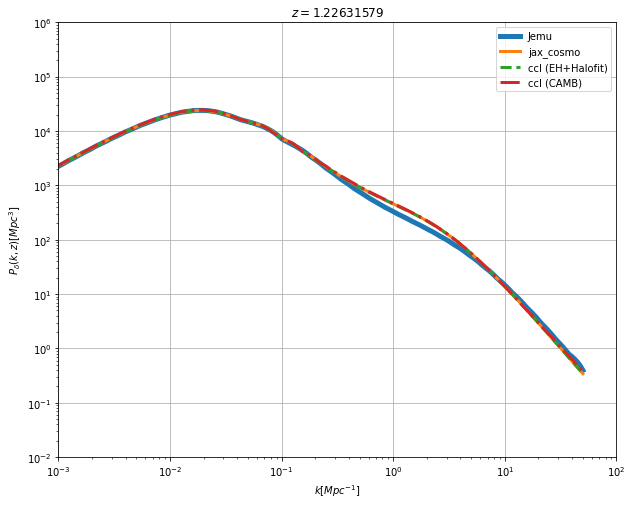

In [244]:
plt.figure(figsize=(10,8))
plt.plot(k_star,pk_nl,lw=5, label="Jemu")
plt.plot(k_star,pk_nonlin_jc,lw=3, label="jax_cosmo")
plt.plot(k_star,pk_nonlin_ccl_EH,lw=3, ls="--",label="ccl (EH+Halofit)")
plt.plot(k_star,pk_nonlin_ccl_CAMB_nus,lw=3, ls="-.",label="ccl (CAMB)")
#plt.plot(k_star,pk_nl, lw=1,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(rf"$z={z_star}$");
plt.xlim([1e-3,1e2])
plt.ylim([1e-2,1e6])

In [245]:
thetabin=0
cosmologies[thetabin]

array([0.12616742, 0.02163407, 2.72607173, 1.15724975, 0.73022459])

In [246]:
zbin=5
zs[zbin]

DeviceArray(1.22631579, dtype=float64)

In [247]:
gF = growth_factor[thetabin,zbin]

In [248]:
pklinz0 = pk_linear[thetabin]

In [249]:
pklin= gF * pklinz0

In [250]:
Qf = (1+q_function[thetabin]).reshape(st.nk, st.nz)

In [251]:
Qf[:,zbin]

array([ 0.99986602,  0.99999775,  1.00011473,  1.00017474,  1.00018809,
        1.00018066,  1.0001584 ,  1.00011355,  0.99999133,  0.9997263 ,
        0.999335  ,  0.99872325,  0.99761778,  0.995824  ,  0.99315682,
        0.98943443,  0.98342698,  0.9756921 ,  0.97295959,  0.96879068,
        0.97875946,  1.01432346,  1.09366204,  1.23405339,  1.48134456,
        1.89142029,  2.54416557,  3.54033275,  4.99061181,  6.98572256,
        9.54117149, 12.52975519, 15.67984215, 18.70015122, 21.403456  ,
       23.73057904, 25.72161919, 27.47079952, 29.08981738, 30.69325875])

In [252]:
pknl = pklin * Qf[:,zbin]

In [253]:
#rescaling

In [254]:
h = cosmologies[thetabin][-1]

In [255]:
h

0.7302245918893255

In [256]:
pklin /= h**2
pknl /= h**2

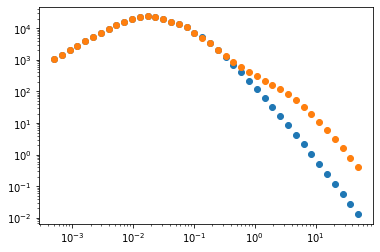

In [257]:
plt.scatter(ks,pklin,label='train Plin')
plt.scatter(ks,pknl,label='train Pnl')
plt.xscale("log")
plt.yscale("log")

(0.01, 1000000.0)

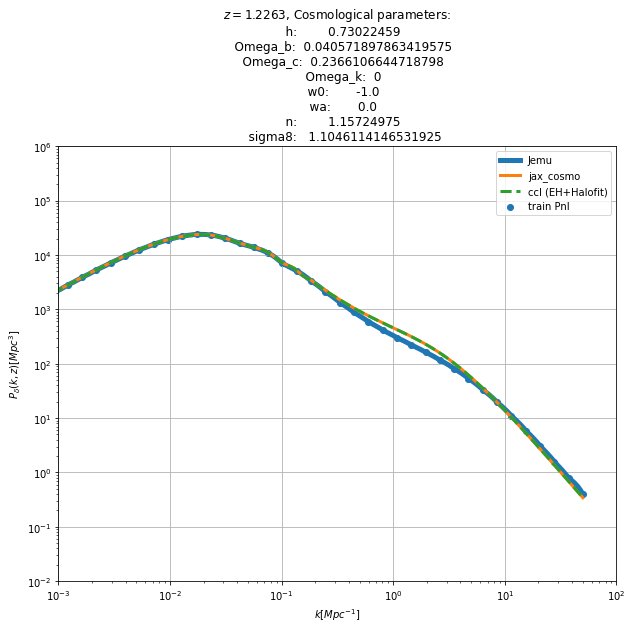

In [258]:
plt.figure(figsize=(10,8))
plt.plot(k_star,pk_nl,lw=5, label="Jemu")
plt.plot(k_star,pk_nonlin_jc,lw=3, label="jax_cosmo")
plt.plot(k_star,pk_nonlin_ccl_EH,lw=3, ls="--",label="ccl (EH+Halofit)")
#plt.scatter(ks,pklin,label='train Plin')
plt.scatter(ks,pknl,label='train Pnl')

#plt.plot(k_star,pk_nonlin_ccl_CAMB,lw=3, ls="--",label="ccl (CAMB)")
#plt.plot(k_star,pk_nl, lw=1,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(rf"$z={zs[zbin]:.4f}$, {cosmo_jax}");
plt.xlim([1e-3,1e2])
plt.ylim([1e-2,1e6])